# Point cloud segmentation

In this practical session, we will train a WaffleIron network for point cloud segmentation.

The original research paper is [here](https://arxiv.org/abs/2301.10100). The network is originally designed spcifically for outdoor lidar semantic segmentation.

![](https://github.com/valeoai/WaffleIron/raw/master/illustration.png)


For the sake of GPU resources and computational time, we will create a lighter variation of the model to do part segmentation on the [ShapeNet dataset](https://shapenet.org/).

The objective is not to train a state-of-the-art model, but to grasp the essentials of training for semantic segmentation (with the small modifications specific to part segmentation).

As opposed to previous classification session where, given a point cloud $P$ the objective was to predict the class $c_P$, here the objective is to predict a class for each point in the point cloud: $\{c_p \forall p \in P \}$.




The notebook follows a classic setup for classification pipeline.
1. notebook setup and data preparation
2. data augmentation creation
3. metrics
4. training and validation loop
5. network definition

### Notebook and data setup

We first import the librairies needed for the practical session.

In [ ]:
from huggingface_hub import hf_hub_download
import os
import json
from sklearn.metrics import confusion_matrix
import plotly.graph_objects as go # for visualization
import tqdm
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.spatial import KDTree
import matplotlib.pyplot as plt

The next block download the shapenet dataset for part segmentation, unzip the archive and rename the folder as `shape_data`.

In [ ]:
hf_hub_download(repo_id="wangps/shapenet_segmentation", filename="shapenetcore_partanno_segmentation_benchmark_v0_normal.zip", repo_type="dataset", cache_dir=".")
!unzip -qq ./datasets--wangps--shapenet_segmentation/snapshots/dbde146b974e1fc8628b47b1b1c4e50d8bc1a2ef/shapenetcore_partanno_segmentation_benchmark_v0_normal
!mv shapenetcore_partanno_segmentation_benchmark_v0_normal shape_data

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)nno_segmentation_benchmark_v0_normal.zip:   0%|          | 0.00/707M [00:00<?, ?B/s]

We then define the variables for path to the files containing the lists of shape filenames for training and validation split.

In [ ]:
train_files = "shape_data/train_test_split/shuffled_train_file_list.json"
val_files = "shape_data/train_test_split/shuffled_val_file_list.json"

As usual, we define the function for visualization.

In [ ]:
# display the point cloud
def point_cloud_visu(pts, cls=None):

    marker_dict = dict(size=3,
                            color=cls,
                            )

    if (cls is not None) and (
        len(cls.shape)==1 or
        (len(cls.shape)==2 and (cls.shape[1]==1))):
      marker_dict["colorscale"] = 'Viridis'

    fig = go.Figure(
        data=[
            go.Scatter3d(
                x=pts[:,0], y=pts[:,1], z=pts[:,2],
                mode='markers',
                marker=marker_dict,
            )
        ],
        layout=dict(
            scene=dict(
                xaxis=dict(visible=False),
                yaxis=dict(visible=False),
                zaxis=dict(visible=False),
                aspectmode="data", #this string can be 'data', 'cube', 'auto', 'manual'
                #a custom aspectratio is defined as follows:
                aspectratio=dict(x=1, y=1, z=0.95)
            )
        )
    )
    fig.show()

We then create two functions:
- `load_files`: function for loading the files for given split
- `load_data`: function for loading one point cloud from a filename

Points are converted from numpy to tensors.

In [ ]:
def load_files(files):
  return json.load(open(files))

def load_data(filename):
  data = np.loadtxt(filename+".txt")
  points = data[:,[0,2,1]]
  labels = data[:,6]
  points = torch.tensor(points, dtype=torch.float)
  labels = torch.tensor(labels, dtype=torch.long)
  return points, labels

files = load_files(train_files)
points, labels = load_data(files[1])
point_cloud_visu(points, labels)

## Transformations

As in the previous practical session, we first define the transformations used in processing pipeline to create / augment the point clouds.

#### Random decimation
First tranformation is the random decimation of the point clouds. Note that as opposed to classification, the labels must be decimated as well.

**Question 1:** Fill the `RandomDecimation` class.

In [ ]:
class RandomDecimation:
  def __init__(self, num_points) -> None:
     self.n_pts = num_points

  def __call__(self, data_dict):
    # fill here
    points = data_dict["points"]
    labels = data_dict["labels"]
    ids = torch.randperm(points.shape[0],dtype=torch.long)[:self.n_pts]
    data_dict["points"] = points[ids]
    data_dict["labels"] = labels[ids]
    return data_dict

files = load_files(train_files)
points, labels = load_data(files[1])
data_dict = {"points":points, "labels":labels}
transform = RandomDecimation(512)
data_dict = transform(data_dict)
points_t1 = data_dict["points"] + torch.tensor([1.,0,0])
points = torch.cat([points, points_t1], dim=0)
labels = torch.cat([labels, data_dict["labels"]])
point_cloud_visu(points, labels)

#### Random rotation around the $z$-axis

The random rotation around the $z$, draws a random angle and the operate the corresponding rotation. Note that, as the order of the points is not changed, there is no need to modify the labels.

**Question 2:** fill the `RandomRotationZ` class.

In [ ]:
class RandomRotationZ:
  def __call__(self, data_dict):
    # fill here
    points = data_dict["points"]
    theta = (torch.rand((1,)) * torch.pi * 2).item()
    rot = torch.tensor(
        [[ np.cos(theta), np.sin(theta), 0],
         [-np.sin(theta), np.cos(theta), 0],
         [             0,             0, 1]], dtype=torch.float)
    data_dict["points"] = points@rot
    return data_dict

files = load_files(train_files)
points, labels = load_data(files[1])
data_dict = {"points":points, "labels":labels}
transform = RandomRotationZ()
data_dict = transform(data_dict)
points_t1 = data_dict["points"] + torch.tensor([1.,0,0])
points = torch.cat([points, points_t1], dim=0)
labels = torch.cat([labels, data_dict["labels"]])
point_cloud_visu(points, labels)

#### Random scaling

The random scaling draws a scale factor in the range $[s_\min, s_\max]$ and multiply the coordinates of the point cloud by this factor. Note that, as the order of the points is not changed, there is no need to modify the labels.

**Question 3** fill the `RandomScale` class.

In [ ]:
class RandomScale:
    def __init__(self, scale_min, scale_max):
      self.mini = scale_min
      self.maxi = scale_max

    def __call__(self, data_dict):
      points = data_dict["points"]
      scale_factor = torch.rand((1,)).item() * (self.maxi - self.mini) + self.mini
      data_dict["points"] = points * scale_factor
      return data_dict

files = load_files(train_files)
points, labels = load_data(files[1])
data_dict = {"points":points, "labels":labels}
transform = RandomScale(0.1,2)
data_dict = transform(data_dict)
points_t1 = data_dict["points"] + torch.tensor([1.,0,0])
points = torch.cat([points, points_t1], dim=0)
labels = torch.cat([labels, data_dict["labels"]])
point_cloud_visu(points, labels)

#### Project to a plane

WaffeIron consists of blocks made of two sub-blocks (see figure).

The first one is a spatial mixing block, which first projec the points to one of the principal planes ($(x,y), (y,z), (z,x)$) and run $3\times3$ convolution on the generated images to finally reproject the features to the points.

The second one is a fetaure mixing blocks, very similar to the MLP part of the PointNet network. It consists in applying a small MLP on the point features.

Both blocks use a residual connection.

In order to do this projection, we will compute the projection indices in the three planes.

The projection to planes takes as parameter the image size that will be generated (it will a square one).

In the `__call__` method, we iterate over the dimension list (`self.dims`) that are couples of the dimensions we keep to generate the projection.

The function then:
- rescales the 2D points to $[0, \text{self.im_size}]$ (we consider for constant projections that the bounds of the points are $[-0.5,0.5]$)
- converts the 2D points to intergral coordinates
- clip the coordinates to $[0, \text{self.im_size}-1]$ (because to scaling there may points that are outside the image)
- convert the 2D to 1D-coordinate ($(x,y) \rightarrow x * \text{self.im_size} + y$)

It returns the 3 set of coordinates (one for each plane).

**Question 4**: fill the `ProjectionToPlane` class.

To know if your code correctly working, here is the results of the sample code.

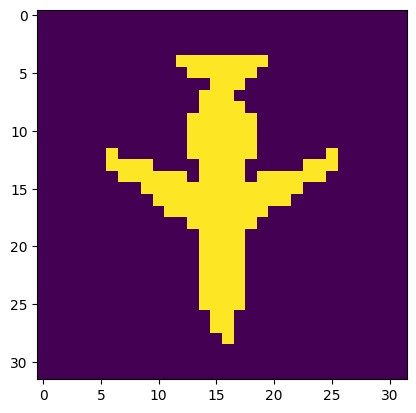

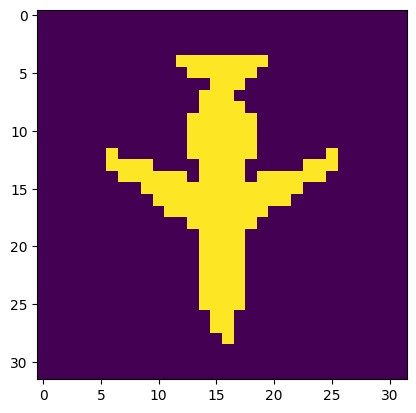

In [ ]:
class ProjectionToPlane:
  def __init__(self, im_size):
    self.im_size = im_size
    self.dims = [[0,1], [1,2], [0,2]]

  def __call__(self, data_dict):
    points = data_dict["points"]

    indices = []
    for dims in self.dims:
      pts = points[:,dims]
      pts = (pts + 0.5) * self.im_size
      pts = pts.long()
      pts = torch.clip(pts, 0, self.im_size-1)
      ids = pts[:,0] * self.im_size + pts[:,1]
      indices.append(ids)
    indices = torch.stack(indices, dim=0)
    data_dict["indices"] = indices.long()
    return data_dict


files = load_files(train_files)
points, labels = load_data(files[1])
data_dict = {"points":points, "labels":labels}
im_size = 32
transform = ProjectionToPlane(im_size)
data_dict = transform(data_dict)
im = torch.zeros((im_size**2), dtype=torch.long)
im[data_dict["indices"][0]] = 1
im = im.reshape((im_size,im_size))
plt.imshow(im)


#### Composition

As for the classification practical session, we need a class that will do all the transformation by iterating over a list given as parameter.

**Question 5** fill the `Compose` class.

In [ ]:
class Compose:
  def __init__(self, transform_list):
    self.t = transform_list

  def __call__(self, data_dict):
    for t in self.t:
      data_dict = t(data_dict)
    return data_dict

transform = Compose(
    [
        RandomDecimation(1024),
        RandomRotationZ(),
        RandomScale(0.9,1.1),
        ProjectionToPlane(32),
    ])

files = load_files(train_files)
points, labels = load_data(files[1])
data_dict = {"points":points, "labels":labels}
data_dict = transform(data_dict)
points_t1 = data_dict["points"] + torch.tensor([1.,0,0])
points = torch.cat([points, points_t1], dim=0)
labels = torch.cat([labels, data_dict["labels"]])
point_cloud_visu(points, labels)



## Dataset

**Question 6:** implement the dataset for ShapeNet part.
- the argument is `split` (train or val), which allows loading the data for the train or the val split.
- `__len__` return the number of samples in the split
- `forward` loads (for a sample id `idx`) the corresponding data, applies a transformation if there is one (should have been stored in `self.transform`), and returns dictionary with the fields `points` and `labels`.

In [ ]:
# create the dataloader
class ShapeNetPart(Dataset):

  def __init__(self, split, transforms=None) -> None:
    super().__init__()

    if split == "train":
      self.files = load_files("shape_data/train_test_split/shuffled_train_file_list.json")
    elif split == "val":
      self.files = load_files("shape_data/train_test_split/shuffled_val_file_list.json")

    self.transforms = transforms


  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):

    filename = self.files[idx]
    points, labels = load_data(filename)
    data_dict = {"points": points, "labels": labels}

    if self.transforms is not None:
      data_dict = self.transforms(data_dict)

    return data_dict

train_transforms = Compose(
    [
        RandomDecimation(512),
        RandomRotationZ(),
        RandomScale(0.9,1.1),
        ProjectionToPlane(32),
    ])

train_dataset = ShapeNetPart("train", transforms=train_transforms)
data_dict = train_dataset[1]
point_cloud_visu(data_dict["points"], data_dict["labels"])

## Network definition

In this section, we define the WaffleIron network.
It is composed of three main component.
- a point embedding
- a backbone, composed of sucession of WaffleIron blocks
- a classification head

#### Point embedding

In the original implementation, the point embedding is a DGCNN block.
In this session, we replace it by a simple linear layer (implemented with 1D-convolution).

**Question 7:** fill the `Embedding` class.

In [ ]:
class Embedding(torch.nn.Module):
  def __init__(self, in_channel: int, out_channel: int) -> None:
    super().__init__()
    self.in_c = in_channel
    self.out_c = out_channel
    self.layers = torch.nn.Conv1d(self.in_c, self.out_c,1)
  def forward(self, x):
    # x dimension is [B C N]
    return self.layers(x)

#### Classification head

Similarly for the classification head, we also use a single linear layer (implemented with a Conv1d).
It is possible to use more complex heads, but to limit the computational requirements, we limit ourselves to the simplest one.

**Question 8:** fill the `ClassificationHead` class.

In [ ]:
class ClassificationHead(torch.nn.Module):
  def __init__(self, in_channel: int, out_channel: int) -> None:
    super().__init__()
    self.in_c = in_channel
    self.out_c = out_channel
    self.layers = torch.nn.Conv1d(self.in_c, self.out_c,1)
  def forward(self, x):
    # x dimension is [B C N]
    return self.layers(x)

#### Channel mixing

The channel mixing block correspond to the right part of the $\times L$ series of blocks.
This block operates per-point operations:
- a batchnorm
- an MLP (two layers with ReLU activation)
- a residual connection with the output
During the whole process the feature dimensions stays equal to $C$ (`channels` variable in the code).

**Question 9:** fill the `ChannelMixing` class.

In [ ]:
class ChannelMixing(torch.nn.Module):
  def __init__(self, channels):
    super().__init__()
    self.layers = torch.nn.Sequential(
        torch.nn.BatchNorm1d(channels),
        torch.nn.Conv1d(channels, channels, 1),
        torch.nn.ReLU(inplace=True),
        torch.nn.Conv1d(channels, channels, 1),
    )
  def forward(self, x: torch.Tensor) -> torch.Tensor:
    x_mix = self.layers(x)
    return x + x_mix



print(data_dict.keys())
x = data_dict["points"].unsqueeze(0).permute(0,2,1)
ids = data_dict["indices"].unsqueeze(0)
print(ids.shape, x.shape)
net = ChannelMixing(3)
print(net(x).shape)

dict_keys(['points', 'labels', 'indices'])
torch.Size([1, 3, 512]) torch.Size([1, 3, 512])
torch.Size([1, 3, 512])


#### Spatial mixing

Spatial mixing (WI block on the figure) is the core of the method.
The objective of this block (as in [MLP-Mixer](https://arxiv.org/abs/2105.01601)) is to create relations between adjacent points.
One way would be to setup a point convolution layer, but that is costly.
Instead, points are projected on a plane where a small convolutional network is applied (mixing), then we operate an un-projection operation to get the features back to the points.

The spatial mixing operates several operation on the input:
1. a batchnorm is applied on the input
2. the indices (shape $[B,N]$) are expanded to shape $[B, C, N]$.
3. the points are projected on the planes using the indices (computed in the augmentations), it fills a grid of size $[B, C, G^2]$, where $G$ is the grid size. Use the `scatter_reduce_` function of torch [DOCS](https://pytorch.org/docs/stable/generated/torch.Tensor.scatter_reduce_.html#torch.Tensor.scatter_reduce_) (we do an average reduction).
4. the grid is reshaped to $[B, C, G, G]$
5. The grid goes to the convolutional layer made of 2 $3 \times 3$ convolutional layers, with a ReLU in between.
6. the grid is reshaped to $[B, C, G^2]$
7. the features are un-projected to the points using a `torch.gather` [DOCS](https://pytorch.org/docs/stable/generated/torch.gather.html), that is the inverse operation of the scattering.
8. we apply a residual connection with the input.


**Question 10:** fill the `SpatialMixing` class.

In [ ]:
class SpatialMixing(torch.nn.Module):
  def __init__(self, channels: int, grid_size) -> None:
     super().__init__()
     self.norm = torch.nn.BatchNorm1d(channels)
     self.grid_size = grid_size
     self.layers = torch.nn.Sequential(
         torch.nn.Conv2d(channels, channels, 3, padding=1),
         torch.nn.ReLU(inplace=True),
         torch.nn.Conv2d(channels, channels, 3, padding=1),
     )
  def forward(self, x: torch.Tensor, indices: torch.Tensor):
    # normalize
    x_mix = self.norm(x) # [B, C, N]

    # project on the plane
    ids = indices.unsqueeze(1).expand(-1, x_mix.shape[1], -1)
    grid = torch.zeros((x_mix.shape[0], x_mix.shape[1], self.grid_size**2), dtype=x_mix.dtype, device=x_mix.device)
    grid = grid.scatter_reduce_(2, ids, x_mix, include_self=False, reduce="mean")
    grid = grid.reshape(grid.shape[0:2]+(self.grid_size, self.grid_size))
    grid = self.layers(grid)
    grid = grid.reshape(grid.shape[0:2]+(self.grid_size*self.grid_size,))
    x_mix = torch.gather(grid, 2, ids)

    return x + x_mix

print(data_dict.keys())
x = data_dict["points"].unsqueeze(0).permute(0,2,1)
ids = data_dict["indices"].unsqueeze(0)
print(ids.shape, x.shape)
net = SpatialMixing(3,32)
print(net(x, ids[:,0]).shape)


dict_keys(['points', 'labels', 'indices'])
torch.Size([1, 3, 512]) torch.Size([1, 3, 512])
torch.Size([1, 3, 512])


#### Block

The `WaffleIronBlock` class is simply a spatial mixing block followed by the channel mixing block.

**Question 11:** fill the `WaffleIronBlock` class.

In [ ]:
class WaffleIronBlock(torch.nn.Module):
  def __init__(self, channels, grid_size):
    super().__init__()
    self.spatial_mix = SpatialMixing(channels, grid_size)
    self.channel_mix = ChannelMixing(channels)

  def forward(self, x: torch.Tensor, indices: torch.Tensor) -> torch.Tensor:
    x = self.spatial_mix(x, indices)
    x = self.channel_mix(x)
    return x

#### Network

Finally, we buid the the network.
It composed of:
- a `PointEmbedding`
- `block_num` `WaffleIronBlock` blocks (you can create a list and use the `torch.nn.ModuleList` [DOCS](https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html)
- a classification head

The forward method:
- gets the points from the data dictionary (shape $[B, N, C]$)
- permutes to the dimensions to get shape $[B, C, N]$
- applies the embedding
- applies the blocks, with the indices corresponding to the plane to be projected (indices are of shape $[B, P, N]$) so the indices should be selected along the $P$ dimension with $p = i \% P $, where i in the index of the block.
- applies the classification head.

**Question 12:** fill the `WaffleIron` class.

In [ ]:
class WaffleIron(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels, out_channels, block_num, grid_size):
    super().__init__()
    self.embedding = Embedding(in_channels, hidden_channels)
    self.classif_head = ClassificationHead(hidden_channels, out_channels)
    blocks = [WaffleIronBlock(hidden_channels, grid_size) for _ in range(block_num)]
    self.blocks = torch.nn.ModuleList(blocks)


  def forward(self , data_dict):
    points = data_dict["points"].permute(0,2,1)
    x = self.embedding(points)
    indices = data_dict["indices"].permute(1,0,2)
    P = indices.shape[0] # number of plane indices
    for i, block in enumerate(self.blocks):
      ids = indices[i%P]
      x = block(x, ids)

    x = self.classif_head(x)
    return x


network = WaffleIron(3,32,50, 6, 32)
train_dataset = ShapeNetPart("train", transforms=train_transforms)
data_dict = train_dataset[1]
data_dict["points"] = data_dict["points"].unsqueeze(0)
data_dict["indices"] = data_dict["indices"].unsqueeze(0)
predictions = network(data_dict)
print(predictions.shape)


torch.Size([1, 50, 512])


## Metrics

We now define the metrics.

**Question 13:** fill the `conf_matrix` function.

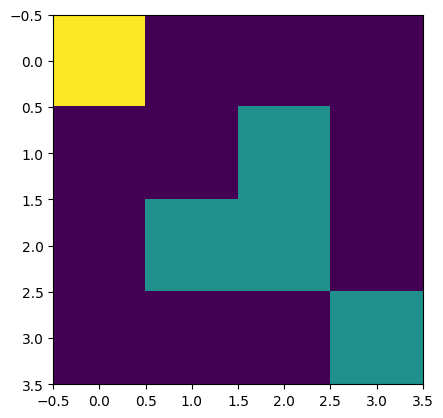

In [ ]:
def conf_matrix(predictions, batch, num_classes):
  pred_labels = torch.argmax(predictions, dim=1).cpu().numpy()
  labels = batch["labels"].cpu().numpy()
  cm = confusion_matrix(labels.ravel(), pred_labels.ravel(), labels=torch.arange(num_classes))
  return cm

predictions = torch.tensor([[0.1, 0.2, 0.7, 0.0],
               [0.0, 0.6, 0.1, 0.3],
               [0.8, 0.2, 0.0, 0.0],
               [0.9, 0.0, 0.0, 0.1],
               [0.1, 0.2, 0.0, 0.6],
               [0.1, 0.4, 0.5, 0.0],
               ], dtype=torch.float)
labels = torch.tensor([2,2,0,0,3,1])
batch = {"labels": labels}
cm = conf_matrix(predictions, batch, 4)
plt.imshow(cm)

#### Global accuracy
**Question 14:** fill the `global_accuracy` function. (From example, it should output 0.67)

In [ ]:
def global_accuracy(cm):
  return np.diag(cm).sum() / cm.sum()
print(global_accuracy(cm))

0.6666666666666666


#### Accuracy per class

**Question 15:** fill the `accuracy_per_class` function. (example should give [1.  0.  0.5 1. ])

In [ ]:
def accuracy_per_class(cm):
  tp = np.diag(cm)
  tp_fn = cm.sum(axis=1)
  tp_fn[tp_fn==0] = 1
  return tp / tp_fn

print(accuracy_per_class(cm))

[1.  0.  0.5 1. ]


#### IoU and IoU per class

**Question 16:** fill the `iou` function, it returns:
- the average IoU (to compute the average, we remove the classes that are not present)
- the iou per class (not present classes are filled with the average IoU)

Example should return mIoU: 0.58, IoU per class (1., 0., 0.3, 1.).

In [ ]:
def iou(cm):
  tp = np.diag(cm)
  tp_fn = np.sum(cm, axis=1)
  tp_fp = np.sum(cm, axis=0)

  # compute IoU
  mask = (tp_fn == 0)
  IoU = tp / (tp_fn + tp_fp - tp + mask)

  # replace IoU with 0 by the average IoU
  aIoU = IoU[np.logical_not(mask)].mean(axis=-1, keepdims=True)
  IoU += mask * aIoU

  return IoU.mean(), IoU

print(iou(cm))

(np.float64(0.5833333333333333), array([1.        , 0.        , 0.33333333, 1.        ]))


**Question 17**: implement the get metrics function which returns a dictionary with the accuracy, the average accuracy, the accuracy per class, the IoU and the IoU per class, and the confusion matrix.

In [ ]:
def get_metrics(cm):
  acc = global_accuracy(cm)
  acc_class = accuracy_per_class(cm)
  macc = acc_class.mean()
  mIoU, IoU_class = iou(cm)

  return {"accuracy": acc,
          "accuracy_per_class": acc_class,
          "average_accuracy": macc,
          "confusion_matrix": cm,
          "average_iou": mIoU,
          "iou_per_class": IoU_class,
          }

print(get_metrics(cm))

{'accuracy': np.float64(0.6666666666666666), 'accuracy_per_class': array([1. , 0. , 0.5, 1. ]), 'average_accuracy': np.float64(0.625), 'confusion_matrix': array([[2, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 1, 1, 0],
       [0, 0, 0, 1]]), 'average_iou': np.float64(0.5833333333333333), 'iou_per_class': array([1.        , 0.        , 0.33333333, 1.        ])}


## Utility functions

We provide few functions, useful for training:
- `classif_loss`: returns the cross-entropy loss
- `create_optimizer`: creates and returns an AdamW optimizer of the network parameters
- `to_device`: move the data of dictionary, a list or a tensor to the given device.

In [ ]:
def classif_loss(predictions, batch):
  labels = batch["labels"]
  loss = torch.nn.functional.cross_entropy(predictions, labels)
  return loss

def create_optimizer(network):
  optimizer = torch.optim.AdamW(network.parameters(), lr=1e-3)
  return optimizer

def to_device(batch, device):
  if isinstance(batch, torch.Tensor):
    return batch.to(device)
  elif isinstance(batch, list):
    batch_ = []
    for elem in batch:
      if isinstance(elem, torch.Tensor):
        elem = elem.to(device)
      batch_.append(elem)
    return batch_
  elif isinstance(batch, dict):
    batch_ = {}
    for key, elem in batch.items():
      if isinstance(elem, torch.Tensor):
        elem = elem.to(device)
      batch_[key] = elem
    return batch_
  else:
    raise ValueError("unknow batch type")

#### Label masking

One particularity of the part segmentation task, with respect to the semantic segmentation task, is that one evaluates only the segmentation for classes corresponding to the object.

That means that even though we train for 50 classes (the total number of part classes in ShapeNet), we evaluate on 2 to 5 classes (e.g., a plane is 4 classes: main, wings, tail, reactor; a table is 2 classes: legs and top...).

To do so, we will first generate a mask (see image below), with False values for the class ids corresponding to the object, True for the class ids not corresponding to the object.

We give the start index of each class (to which we added a final 50).

**Question 18:** fill the function `create_mask`. It returns the mask and a vector called `label_to_mask` which contains the for given label which line of the mask should be used.


*Note:* mask size `torch.Size([16, 50])`
*Note 2:* `label_to_mask` value `[ 0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 10,
        11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15]`
*Note 3:* a plot of the mask should give the image below.




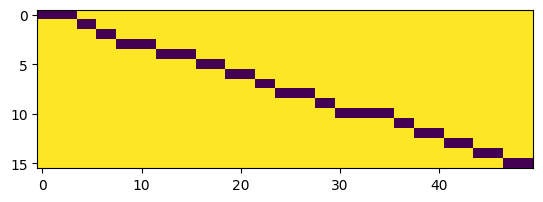

torch.Size([16, 50])
tensor([ 0,  0,  0,  0,  1,  1,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  8,  8,  8,  8,  9,  9, 10, 10, 10, 10, 10, 10,
        11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15])


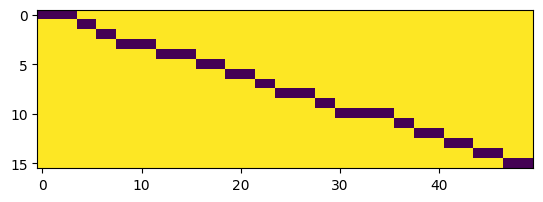

In [ ]:
def create_mask():
  mask = torch.ones((16,50), dtype=torch.bool)
  label_to_mask = torch.ones((50,), dtype=torch.long)
  index_start = [0, 4, 6, 8, 12, 16, 19, 22, 24, 28, 30, 36, 38, 41, 44, 47,50]
  for i in range(len(index_start)-1):
    mask[i, index_start[i]:index_start[i+1]] = 0
    label_to_mask[index_start[i]:index_start[i+1]] = i

  return mask, label_to_mask

mask, label_to_mask = create_mask()

print(mask.shape)
print(label_to_mask)
plt.imshow(mask)

#### Pruning the non object classes

Then given a mask calulated before, and a set of predictions, we mask the predictions of the non-object classes.

The function:
- computes the minimum label for object in the batch (from the groung truth labels contained in `batch`)
- gets the corresponding line in the mask
- applies the mask and set `-1e6` value for the non class object (that force a very low softmax score, thus ignoring these classes)
- returns the update predictions.

**Question 19:** fill the `prune_non_object_classes` function.

In [ ]:

def prune_non_object_classes(predictions, batch, mask, label_to_mask):
  preds = predictions.clone()
  labels = batch["labels"]
  l_min = labels.min(dim=1)[0] # get the minimum label per shape
  masks = mask[label_to_mask[l_min]]
  predictions[masks] = -1e6
  return predictions
  # define the correct range of labels

## Training and validation loops

**Question 20:** code the training loop which perfroms one epoch training. It trains the network (do not forget to put the network in train mode), updates the predictions via `prune_non_object_classes`, maintains a confusion matrix with the predictions for the epochs, and returns the metrics.

In [ ]:
def train_loop(network, train_dataloader, optimizer, num_classes, device):
  network.train()
  train_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
  train_loss = 0
  iter_count = 0


  mask, label_to_mask = create_mask()

  t = tqdm.tqdm(train_dataloader, ncols=100)
  for batch in t:
    batch = to_device(batch, device)
    predictions = network(batch)
    predictions = prune_non_object_classes(predictions, batch, mask, label_to_mask)
    loss = classif_loss(predictions, batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    cm = conf_matrix(predictions, batch, num_classes)
    train_cm += cm
    train_loss += loss.item()
    iter_count += 1

    # batch metrics
    metrics = get_metrics(train_cm)
    t.set_description_str(f"Acc: {metrics['accuracy']*100:.1f}, mAcc: {metrics['average_accuracy']*100:.1f}, mIoU: {metrics['average_iou']*100:.1f}")

  return metrics

**Question 21:** code the validation loop which perfroms the evaluation for the validation set. Do not forget to put the network in eval mode. It updates the predictions via `prune_non_object_classes`, maintains a confusion matrix with the predictions for the epochs, and returns the metrics.

In [ ]:
def val_loop(network, test_dataloader, num_classes, device):
  network.eval()
  test_cm = np.zeros((num_classes, num_classes), dtype=np.int64)
  t = tqdm.tqdm(test_dataloader, ncols=100)


  mask, label_to_mask = create_mask()

  with torch.inference_mode():
    for batch in t:
      batch = to_device(batch, device)
      predictions = network(batch)
      predictions = prune_non_object_classes(predictions, batch, mask, label_to_mask)
      cm = conf_matrix(predictions, batch, num_classes)
      test_cm += cm

      # batch metrics
      metrics = get_metrics(test_cm)
      t.set_description_str(f"Acc: {metrics['accuracy']*100:.1f}, mAcc: {metrics['average_accuracy']*100:.1f}, mIoU: {metrics['average_iou']*100:.1f}")

  return metrics

## Training the network

**Question 22:** train the Waffleiron network. Do not forget to use the `inference_mode` for validation.

Acc: 88.9, mAcc: 70.4, mIoU: 60.8: 100%|██████████████████████████| 234/234 [00:13<00:00, 17.46it/s]


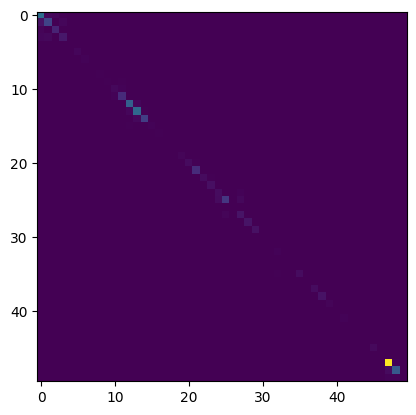

In [ ]:
# number of classes in the datasets and device
num_classes = 50
device = torch.device("cpu")
num_epochs = 5 # will train for 5 epochs, that is low, but OK timewise for a practical session

# Create the network
# network = ...
network = WaffleIron(3,32,50,3,grid_size=16)

# Create the optimizer
# optimizer = ...
optimizer = create_optimizer(network)

# Create the transforms for training
# train_transforms = ...
train_transforms = Compose(
    [
        RandomDecimation(512),
        RandomRotationZ(),
        RandomScale(0.9,1.1),
        ProjectionToPlane(16),
    ])



# create the validation transforms
# val_transforms = ...
val_transforms = Compose(
    [
        RandomDecimation(1024),
        ProjectionToPlane(16),
    ]
    )

# create the train dataset and val dataset
train_dataset = ShapeNetPart("train", transforms=train_transforms)
val_dataset = ShapeNetPart("val", transforms=train_transforms)

# create the train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=1)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=1)

# loop over the epochs
# and train / val the network
# ...
for epoch in range(num_epochs):
  train_loop(network, train_dataloader, optimizer, num_classes, device)
  metrics = val_loop(network, val_dataloader, num_classes, device)

plt.imshow(metrics["confusion_matrix"])

## Result visualization

Looking at the confusion matrix is nice but visual inspection of the results is also needed.

**Question 23:** predict the labels for the first few point clouds in the validation dataloader, apply translations to them and visualize them along with the predicted labels.

In [ ]:
network.eval()

pts = []
lbs = []
with torch.inference_mode():
  for j, batch in enumerate(val_dataloader):
    batch = to_device(batch, device)
    predictions = network(batch)
    predictions = prune_non_object_classes(predictions, batch, mask, label_to_mask)
    predictions = torch.argmax(predictions, dim=1)
    for i in range(batch["points"].shape[0]):
      batch["points"][i,:,0] += i
      batch["points"][i,:,1] += j
      predictions[i] -= predictions[i].min()
    pts.append(batch["points"].reshape(-1,3))
    lbs.append(predictions.reshape(-1))
    if j>=7:
      break
pts = torch.cat(pts, dim=0)
lbs = torch.cat(lbs, dim=0)
point_cloud_visu(pts, lbs)